# 1. Import and Install Dependencies

In [ ]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [1]:
import cv2
import numpy as np
import os


In [2]:
import pyzed.sl as sl

# 2. Setup Folders for Collection

In [4]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['boxing', 'notFighting', 'kick'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [5]:
# create the folder DATA_PATH if it does not exist and make all the actions as subfolders
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [6]:
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass

# 3. Setup ZED2i

In [7]:
def draw_skeleton(frame, keypoint_2d):
    # Define connections between keypoints, e.g., [(0, 1), (1, 2), ...]
    skeleton_pairs = [
        # Spine
        (0, 1), (1, 2), (2, 3), (3, 4),
        # Head
        (4, 5), (5, 6), (5, 7), (6, 8), (7, 9),
        # Arms
        (4, 10), (10, 12), (12, 14), (14, 16),  # Left arm
        (4, 11), (11, 13), (13, 15), (15, 17),  # Right arm
        # Legs
        (0, 18), (18, 20), (20, 22), (22, 24), (22, 26), (22, 28),  # Left leg
        (0, 19), (19, 21), (21, 23), (23, 25), (23, 27), (23, 29),  # Right leg
        # Fingers (only showing the first and last joint for brevity)
        (16, 30), (16, 32), (16, 34), (16, 36),  # Left hand fingers
        (17, 31), (17, 33), (17, 35), (17, 37),  # Right hand fingers
    ]


    for start, end in skeleton_pairs:
        start_point = tuple(map(int, keypoint_2d[start]))
        end_point = tuple(map(int, keypoint_2d[end]))

        # Draw lines for bones
        cv2.line(frame, start_point, end_point, (0, 255, 0), 2)

        # Draw circles for joints
        cv2.circle(frame, start_point, 3, (0, 0, 255), -1)
        cv2.circle(frame, end_point, 3, (0, 0, 255), -1)

# 5. Collect Keypoint Values for Training and Testing

In [8]:
import csv
def write_keypoints_to_csv(action_class, keypoints, filename):
    #Create a header for the CSV file
    header = ['class']
    for val in range(1, len(keypoints) + 1):
        header.append(f"x{val}")
        header.append(f"y{val}")

    #f
    # Flatten the keypoints list
    flat_keypoints = [coord for kp in keypoints for coord in kp]

    print(flat_keypoints)
    # Open the CSV file for writing and appending
    with open(filename, mode='a', newline='') as file:
        csv_writer = csv.writer(file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        # Write the header only once at the beginning
        if file.tell() == 0:
            csv_writer.writerow(header)
        
        # Write the keypoints, prefixed with the action class
        row = [action_class] + flat_keypoints
        csv_writer.writerow(row)


def write_keypoints_to_csv3D(action_class, keypoints, filename):
    #Create a header for the CSV file
    header = ['class']
    for val in range(1, len(keypoints) + 1):
        header.append(f"x{val}")
        header.append(f"y{val}")
        header.append(f"z{val}")

    #f
    # Flatten the keypoints list
    flat_keypoints = [coord for kp in keypoints for coord in kp]

    print(flat_keypoints)
    # Open the CSV file for writing and appending
    with open(filename, mode='a', newline='') as file:
        csv_writer = csv.writer(file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        
        # Write the header only once at the beginning
        if file.tell() == 0:
            csv_writer.writerow(header)
        
        # Write the keypoints, prefixed with the action class
        row = [action_class] + flat_keypoints
        csv_writer.writerow(row)



In [9]:

actions = np.array(['boxing', 'notFighting', 'kick'])
no_sequences = 30
sequence_length = 30
DATA_PATH = os.path.join('MP_Data') 


#for actionses in actions:
#    for sequence in range(0, no_sequences + 1):
#        try:
#            os.makedirs(os.path.join(DATA_PATH, actionses, str(sequence)))
#        except:
#            pass


In [ ]:
 # Create a Camera object
zed = sl.Camera()

# Create a InitParameters object and set configuration parameters
init_params = sl.InitParameters()
#init_params.camera_resolution = sl.RESOLUTION.HD720  # Use HD720 video mode
init_params.depth_mode = sl.DEPTH_MODE.PERFORMANCE
init_params.coordinate_units = sl.UNIT.METER
init_params.sdk_verbose = 1

init_params.camera_resolution = sl.RESOLUTION.HD1080
init_params.camera_fps = 30



# Open the camera
err = zed.open(init_params)
if err != sl.ERROR_CODE.SUCCESS:
    print("Camera Open : "+repr(err)+". Exit program.")
    exit()

body_params = sl.BodyTrackingParameters()
# Different model can be chosen, optimizing the runtime or the accuracy
body_params.detection_model = sl.BODY_TRACKING_MODEL.HUMAN_BODY_FAST
body_params.enable_tracking = True
body_params.image_sync = True
body_params.enable_segmentation = False
# Optimize the person joints position, requires more computations
body_params.enable_body_fitting = True
body_params.body_format = sl.BODY_FORMAT.BODY_38

if body_params.enable_tracking:
    positional_tracking_param = sl.PositionalTrackingParameters()
    # positional_tracking_param.set_as_static = True
    positional_tracking_param.set_floor_as_origin = True
    zed.enable_positional_tracking(positional_tracking_param)

print("Body tracking: Loading Module...")

err = zed.enable_body_tracking(body_params)
if err != sl.ERROR_CODE.SUCCESS:
    print("Enable Body Tracking : "+repr(err)+". Exit program.")
    zed.close()
    exit()
bodies = sl.Bodies()
body_runtime_param = sl.BodyTrackingRuntimeParameters()
# For outdoor scene or long range, the confidence should be lowered to avoid missing detections (~20-30)
# For indoor scene or closer range, a higher confidence limits the risk of false positives and increase the precision (~50+)
body_runtime_param.detection_confidence_threshold = 40


cv2.namedWindow("ZED Body Tracking", cv2.WINDOW_NORMAL)
image = sl.Mat()
i = 0 

cap = cv2.VideoCapture(0)
# NEW LOOP
# Loop through actions
for action in actions:
    # Loop through sequences aka videos
    for sequence in range(no_sequences):
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):
            
            if sequence == 0:
                #go to next sequence
                continue
            if zed.grab() == sl.ERROR_CODE.SUCCESS:
                
                zed.retrieve_image(image, sl.VIEW.LEFT)  # Get the image
                frame = image.get_data()  # Convert to OpenCV format
                err = zed.retrieve_bodies(bodies, body_runtime_param)
                if bodies.is_new:
                    body_array = bodies.body_list

                    if len(body_array) > 0:

                        #make a 30 seconds counter before starting to record
                        for body in body_array:

                            body = body_array[0]
                            keypoint_2d = body.keypoint_2d
                            keypoint_3d = body.keypoint
                            draw_skeleton(frame, keypoint_2d)
                            print(keypoint_2d[15])
                            cv2.imshow('OpenCV Feed', frame)

                            # NEW Apply wait logic
                            if frame_num == 0: 
                                cv2.putText(frame, 'STARTING COLLECTION', (120,200), 
                                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                                cv2.putText(frame, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                                # Show to screen
                                cv2.imshow('OpenCV Feed', frame)
                                cv2.waitKey(5000)
                            else: 
                                cv2.putText(frame, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                                # Show to screen
                                cv2.imshow('OpenCV Feed', frame)
                             
                             # NEW Export keypoints
                        #
                            write_keypoints_to_csv3D(action, keypoint_2d, 'keypoints.csv')
#   ##
                            npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                            np.save(npy_path, keypoint_2d)

                            # Break gracefully
                            if cv2.waitKey(10) & 0xFF == ord('q'):
                                break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
keypoint_2d[37]


In [ ]:
#Create a header for the CSV file
header = ['class']
for val in range(1, len(keypoint_3d) + 1):
    print(val)

# 6. Preprocess Data and Create Labels and Features

In [78]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [79]:
label_map = {label:num for num, label in enumerate(actions)}

In [80]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        if sequence == 0:
            continue
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [81]:
np.array(labels).shape

(87,)

In [82]:
X = np.array(sequences)

In [83]:
X.shape

(87, 30, 38, 2)

In [84]:
X = X.reshape((X.shape[0], X.shape[1], -1))


In [85]:
X.shape

(87, 30, 76)

In [86]:
y = to_categorical(labels).astype(int)

In [26]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [27]:
y.shape

(87, 3)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [31]:
X_test.shape

(5, 30, 76)

In [22]:
X_train.shape

(82, 30, 76)

In [23]:
y_train.shape

(82, 3)

In [24]:
y_test.shape

(5, 3)

In [25]:
print(X_test[0])



[[577.81427002 434.84667969 578.43811035 ... 258.00891113 438.98461914
  256.86535645]
 [569.57788086 427.06484985 564.01831055 ... 276.43560791 481.19909668
  309.62887573]
 [570.09564209 426.83627319 564.51617432 ... 274.94033813 476.65237427
  307.37393188]
 ...
 [583.91320801 438.38925171 571.34570312 ... 284.66079712 427.26461792
  336.86636353]
 [583.46252441 439.24533081 570.6574707  ... 286.27325439 425.1605835
  337.62722778]
 [583.1729126  439.64569092 570.13171387 ... 287.59988403 422.96612549
  338.50363159]]


In [26]:
from sklearn.preprocessing import StandardScaler

# Reshape data for scaling
nsamples, nx, ny = X_train.shape
X_train_reshaped = X_train.reshape((nsamples*nx, ny))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)

# Reshape data back to original shape
X_train_scaled = X_train_scaled.reshape((nsamples, nx, ny))

# 7. Build and Train LSTM Neural Network

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.regularizers import l2


In [9]:
log_dir = os.path.join("Logs")
tb_callback= TensorBoard(log_dir=log_dir)

In [10]:
model = Sequential()
model.add(LSTM(32, return_sequences=False, input_shape=(30,76), activation='tanh',
               kernel_regularizer=l2(0.01)))  # L2 regularization
model.add(Dropout(0.5))  # Dropout
model.add(Dense(16, activation="relu"))
#model.add(Dropout(0.5))  # Dropout
model.add(Dense(actions.shape[0], activation="softmax"))


In [11]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.00007, clipnorm=1.0)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [14]:
X_train.shape

NameError: name 'X_train' is not defined

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=100, mode='min', verbose=1)

model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback, early_stopping], validation_split=0.1)


In [ ]:
model.summary()

# Make a prediction

In [ ]:
import numpy as np
import numpy as np
import csv
X_test[0]

#np.savetxt('X_test.txt', X_test[0])
# Save X_test as a CSV file




In [62]:
model.predict(X_test)

1/1 [==============================] - 0s 13ms/step


array([[0.1469996 , 0.02496106, 0.82803935],
       [0.13425815, 0.06969173, 0.7960501 ],
       [0.09813023, 0.07706324, 0.8248065 ],
       [0.80692273, 0.05879116, 0.13428615],
       [0.20251486, 0.03234646, 0.7651387 ]], dtype=float32)

In [61]:
y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [ ]:
X_test.shape

In [ ]:
model.predict(X_test)[2]

In [60]:
actions[np.argmax(model.predict(X_test)[3])]



1/1 [==============================] - 0s 13ms/step


'boxing'

In [ ]:
actions[np.argmax(y_test[3])]

In [ ]:
model.save('modeltest.h5')
del model

# Evaluate

In [ ]:
pwd

In [12]:
model.load_weights('modeltest.h5')

In [15]:
lstm_layer = model.layers[0]

# Extract all weights from the LSTM layer
weights = lstm_layer.get_weights()  # Returns a list of numpy arrays

# LSTM weights include input, recurrent (hidden), and biases
# weights[0] are input weights, [1] are recurrent weights, [2] are biases

# Input weights to the LSTM for skeleton point k
input_weights_k = weights[0][:, 5]

# Output or analyze the extracted weights
print("Input weights for skeleton point k:", input_weights_k)

Input weights for skeleton point k: [-2.83710755e-14  1.92565806e-02 -2.24001780e-02 -1.04908682e-02
 -1.31173320e-02  9.62589093e-06  1.83856599e-02 -1.56522405e-14
 -4.88736946e-03 -2.36360896e-02  3.00621521e-02  1.38705745e-02
  9.35964657e-17  7.42155025e-05  3.96552603e-17  1.03490753e-03
  1.07708566e-07  2.65627051e-17  5.19679406e-06  5.80239948e-03
 -1.23108284e-13 -5.94028206e-05 -1.03053348e-02 -2.20823360e-11
 -8.52790079e-04 -1.60400886e-02 -1.09845549e-02  2.69336905e-03
  8.65242037e-05  1.66993737e-02 -2.51927157e-03  2.08350364e-02
 -1.22282067e-02  1.70384417e-03  1.48542676e-05  3.20490362e-04
  1.05648523e-05  8.35952174e-04  2.98611633e-02 -4.36577247e-03
 -4.58588474e-05 -5.99221203e-05 -1.46082304e-02  1.43704321e-02
  8.07727866e-16  3.78454354e-17 -3.05750500e-02  2.54633225e-04
 -1.54578197e-06  1.98953741e-04  3.20606157e-02  3.84233729e-03
  5.05214754e-17  2.13667825e-02  3.25444825e-02  5.99619932e-03
  3.39846537e-02 -1.59468669e-02  9.91660087e-09  3.73

In [43]:
def compute_accuracy(predictions, labels):
    # Assuming both inputs are numpy arrays and labels are one-hot encoded
    predicted_classes = np.argmax(predictions, axis=-1)
    true_classes = np.argmax(labels, axis=-1)
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy

# Predicting on original data
original_predictions = model.predict(X_test)
original_accuracy = compute_accuracy(original_predictions, y_test)
print(original_accuracy)

num_features = X_test.shape[2]  # Number of skeleton points
importances = np.zeros(num_features)

1/1 [==============================] - 0s 15ms/step
1.0


1/1 [==============================] - 0s 13ms/step


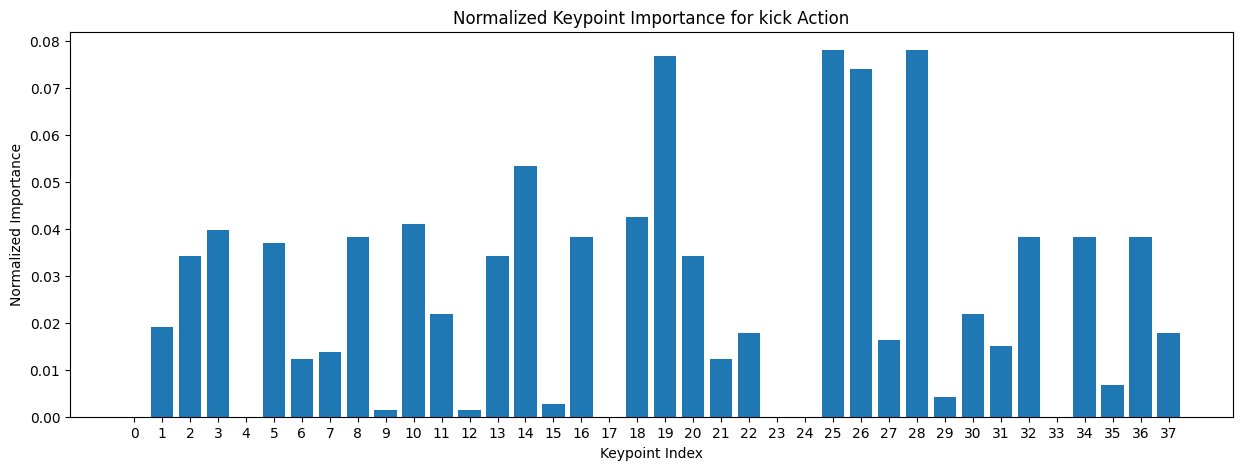

In [105]:
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the variable 'actions' which is an array of action names
# And assuming 'X' and 'y' are your complete datasets before splitting

# Filter out the samples for the 'boxing' action
boxing_index = np.where(np.argmax(y, axis=1) == label_map['boxing'])[0]
X_boxing = X[boxing_index]
y_boxing = y[boxing_index]

# Now, you perform feature ablation on X_boxing

# Predict with the original 'boxing' test set
original_predictions = model.predict(X_boxing)
original_pred_labels = np.argmax(original_predictions, axis=1)
y_boxing_labels = np.argmax(y_boxing, axis=1)
original_accuracy = accuracy_score(y_boxing_labels, original_pred_labels)

# Store the accuracy change for 'boxing'
accuracy_changes_boxing = []

# Perform feature ablation for 'boxing'
for i in range(76):  # Loop over each feature
    X_ablated = X_boxing.copy()
    X_ablated[:, :, i] = 0  # Zero out the feature
    ablated_predictions = model.predict(X_ablated)
    ablated_pred_labels = np.argmax(ablated_predictions, axis=1)
    change_in_accuracy = original_accuracy - accuracy_score(y_boxing_labels, ablated_pred_labels)
    accuracy_changes_boxing.append(change_in_accuracy)

# Calculate and normalize the importance for 'boxing'
keypoint_importance_boxing = np.zeros(38)
for i in range(0, 76, 2):
    keypoint_index = i // 2
    keypoint_importance_boxing[keypoint_index] = accuracy_changes_boxing[i] + accuracy_changes_boxing[i + 1]
keypoint_importance_boxing = np.abs(keypoint_importance_boxing)
normalized_keypoint_importance_boxing = keypoint_importance_boxing / np.sum(keypoint_importance_boxing)

# Plot the importance for 'boxing'
plt.figure(figsize=(15, 5))
plt.bar(range(38), normalized_keypoint_importance_boxing)
plt.title('Normalized Keypoint Importance for kick Action')
plt.xlabel('Keypoint Index')
plt.ylabel('Normalized Importance')
plt.xticks(range(38))  # Add keypoint names if available
plt.show()


1/1 [==============================] - 0s 14ms/step


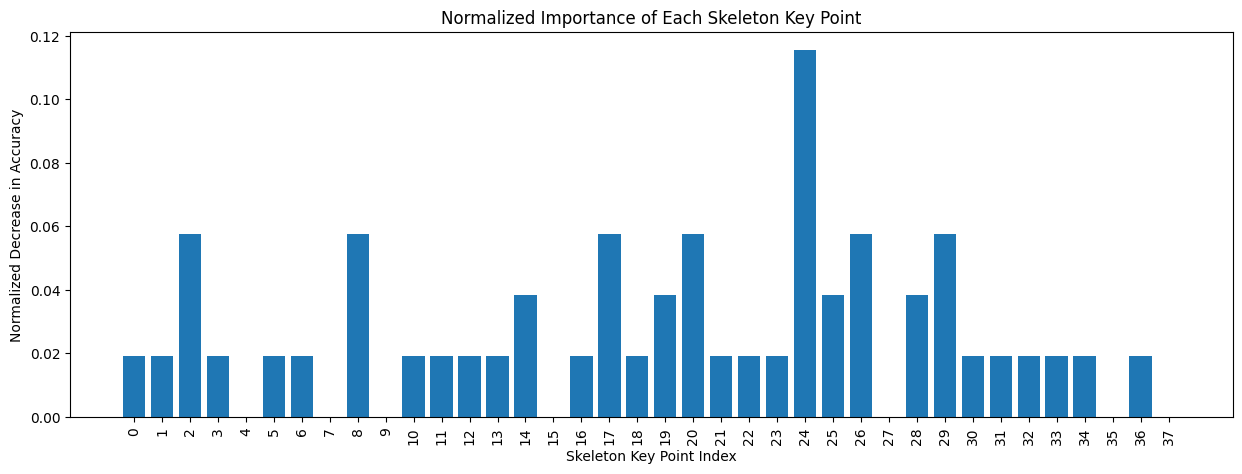

In [65]:
# Predict with the original test set
original_predictions = model.predict(X_test)
# Convert one-hot encoded predictions to label indices
original_pred_labels = np.argmax(original_predictions, axis=1)
# Convert one-hot encoded true labels to label indices
y_test_labels = np.argmax(y_test, axis=1)
# Calculate the original accuracy
original_accuracy = accuracy_score(y_test_labels, original_pred_labels)

# Store the accuracy change
accuracy_changes = []

# Perform feature ablation
for i in range(76):  # Loop over each feature (38 keypoints * 2 for x and y)
    # Copy X_test to not alter original data
    X_ablated = X_test.copy()
    
    # Zero out the feature across all samples and time steps
    X_ablated[:, :, i] = 0
    
    # Predict with the ablated test set
    ablated_predictions = model.predict(X_ablated)
    # Convert one-hot encoded predictions to label indices
    ablated_pred_labels = np.argmax(ablated_predictions, axis=1)
    
    # Calculate the change in accuracy
    change_in_accuracy = original_accuracy - accuracy_score(y_test_labels, ablated_pred_labels)
    accuracy_changes.append(change_in_accuracy)

# Initialize an array for summed importance of keypoints
keypoint_importance = np.zeros(38)

# Sum the importance of x and y for each keypoint
for i in range(0, 76, 2):  # Increment by 2 since we are processing pairs (x, y)
    keypoint_index = i // 2  # Integer division to get keypoint index
    keypoint_importance[keypoint_index] = accuracy_changes[i] + accuracy_changes[i + 1]

# Normalize the importance values
normalized_keypoint_importance = keypoint_importance / np.sum(keypoint_importance)

# Now you can map the keypoint indices back to the names if you have them
# Assuming you have a list or array of keypoint names called 'keypoint_names'
# which should be the same length as 'keypoint_importance'

# Plot the importance of keypoints
plt.figure(figsize=(15, 5))
plt.bar(range(len(normalized_keypoint_importance)), normalized_keypoint_importance)
plt.title('Normalized Importance of Each Skeleton Key Point')
plt.xlabel('Skeleton Key Point Index')
plt.ylabel('Normalized Decrease in Accuracy')
plt.xticks(ticks=range(len(keypoint_names)), labels=keypoint_names, rotation=90)
plt.show()


In [67]:
accuracy_changes

[0.0,
 0.19999999999999996,
 0.19999999999999996,
 0.0,
 0.4,
 0.19999999999999996,
 0.19999999999999996,
 0.0,
 0.0,
 0.0,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.0,
 0.0,
 0.0,
 0.6,
 0.0,
 0.0,
 0.0,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.19999999999999996,
 0.0,
 0.0,
 0.19999999999999996,
 0.0,
 0.6,
 0.0,
 0.0,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.4,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.19999999999999996,
 0.0,
 0.0,
 0.19999999999999996,
 0.8,
 0.4,
 0.19999999999999996,
 0.19999999999999996,
 0.19999999999999996,
 0.4,
 0.0,
 0.0,
 0.19999999999999996,
 0.19999999999999996,
 0.0,
 0.6,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.0,
 0.19999999999999996,
 0.0,
 0.0,
 0.0,
 0.19999999999999996,
 0.0,
 0.0,
 0.0]

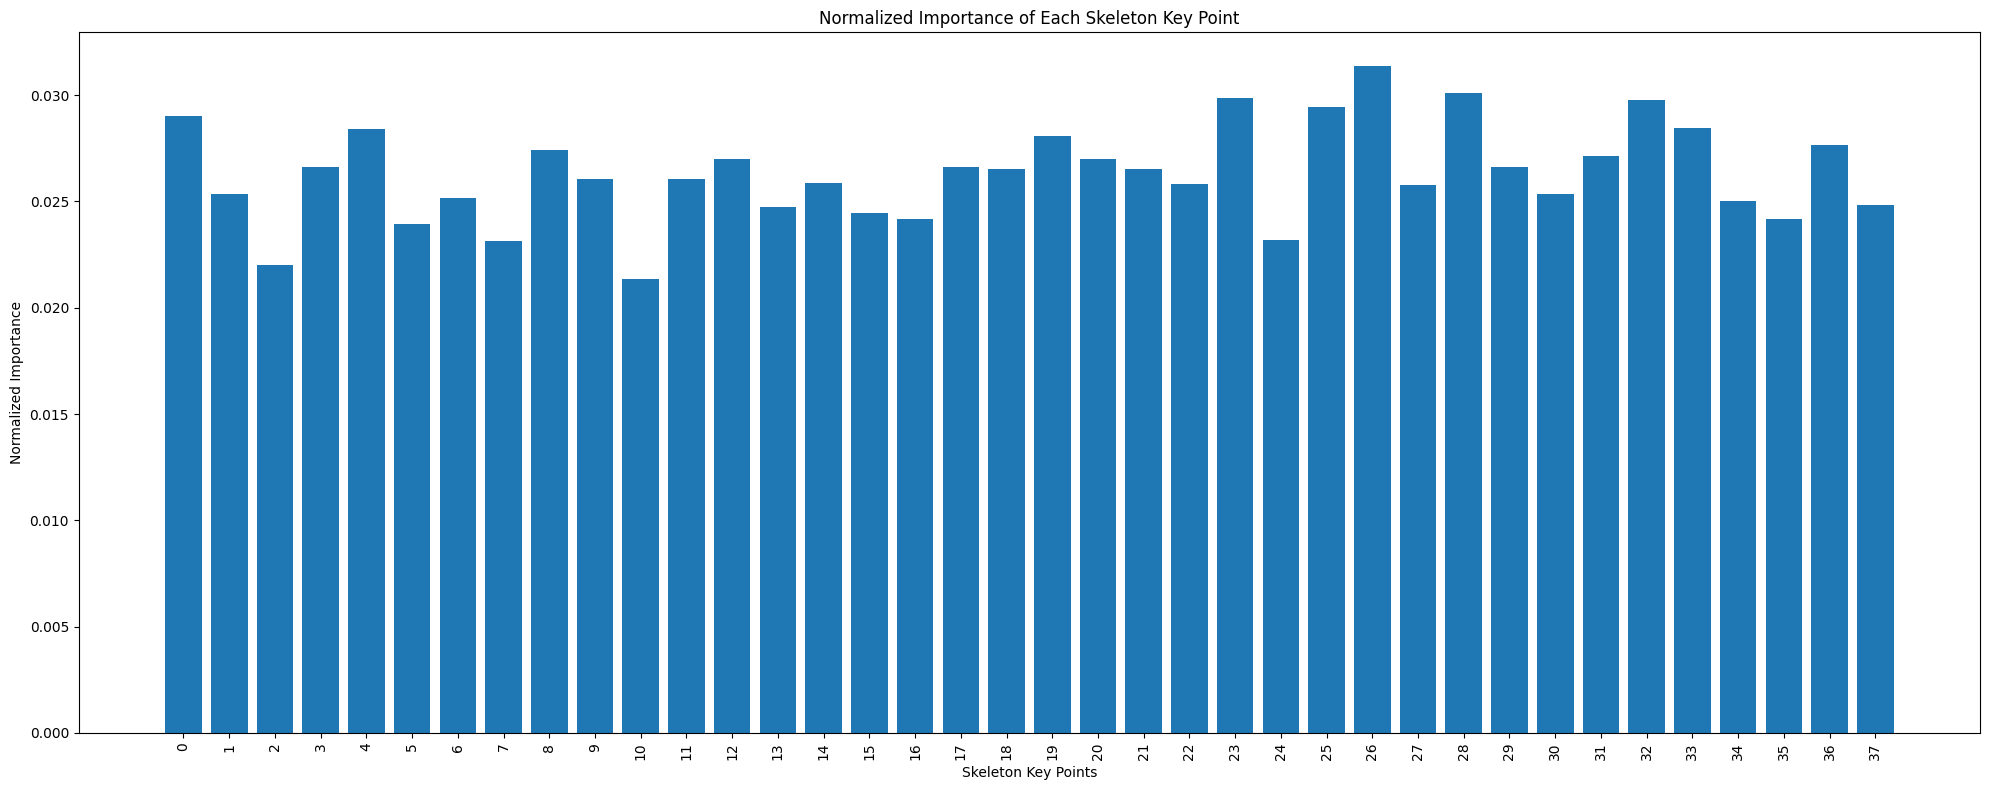

In [53]:
# Get the input weights to the LSTM layer (76, 128)
lstm_layer = model.layers[0]
weights = lstm_layer.get_weights()[0]

# Sum the absolute values of weights for each of the 76 input features
feature_importance = np.sum(np.abs(weights), axis=1)

# Since each keypoint has an x and y coordinate, sum the importances for the x and y of each keypoint
keypoint_importances = np.array([np.sum(feature_importance[i*2:i*2+2]) for i in range(38)])

# Normalize the importances to make them relative
normalized_importances = keypoint_importances / np.sum(keypoint_importances)

# Plotting
plt.figure(figsize=(20, 8))
keypoint_names = [f'{i}' for i in range(38)]  # Replace with actual keypoint names if available
plt.bar(keypoint_names, normalized_importances)
plt.title('Normalized Importance of Each Skeleton Key Point')
plt.xlabel('Skeleton Key Points')
plt.ylabel('Normalized Importance')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout so everything fits without overlapping
plt.show()

In [59]:
keypoint_importances.shape

(38,)

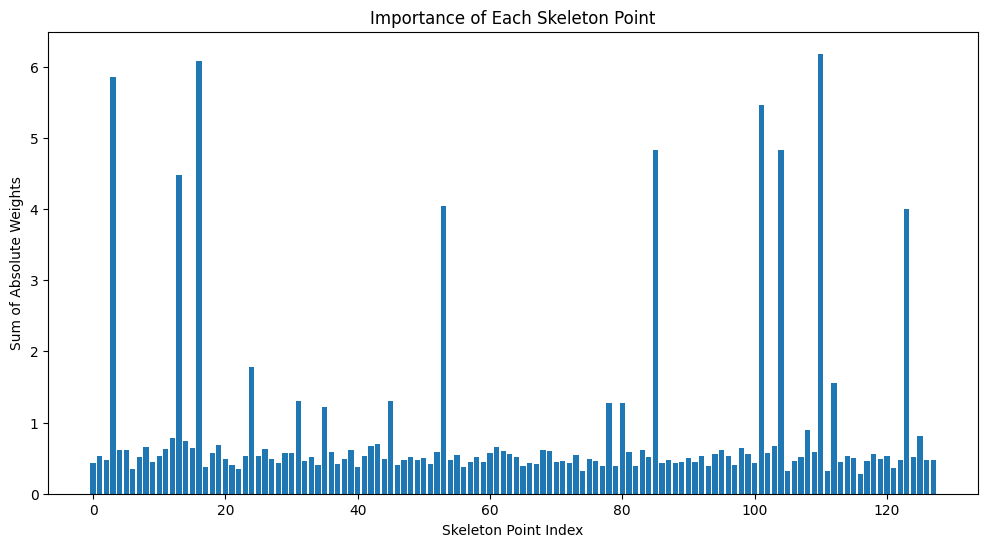

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Example: model with one LSTM layer
lstm_layer = model.layers[0]  # Adjust according to your model structure
weights = lstm_layer.get_weights()[0]  # Get input weights

# Sum of absolute values of weights for each skeleton point
importance = np.sum(np.abs(weights), axis=0)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(len(importance)), importance)
plt.title('Importance of Each Skeleton Point')
plt.xlabel('Skeleton Point Index')
plt.ylabel('Sum of Absolute Weights')
plt.show()


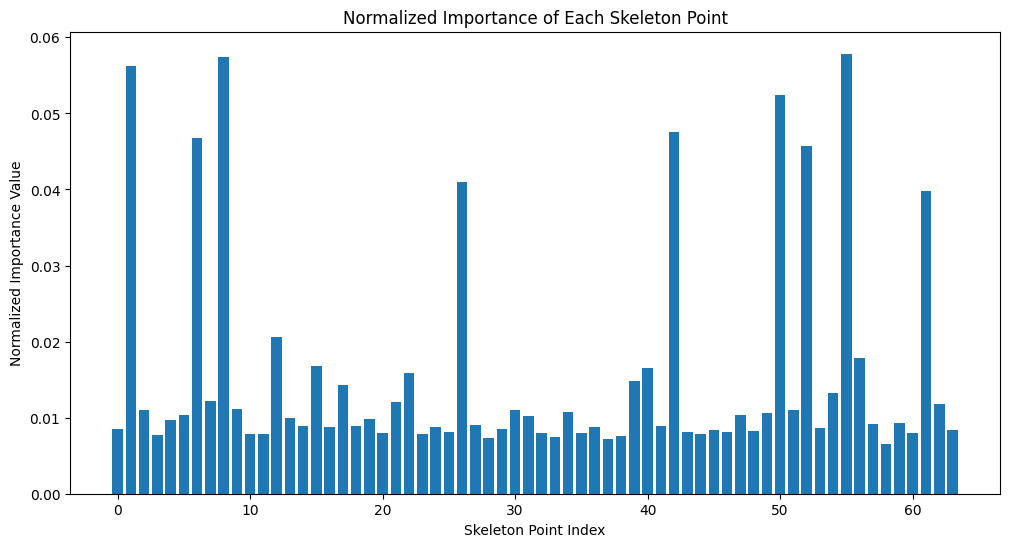

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Let's assume 'weights' is a numpy array of shape (num_time_steps, num_features)
# where num_features is 76 in your case
# The weights could be retrieved similar to the following:
# weights = [layer.get_weights()[0] for layer in model.layers if type(layer) is LSTM][0]

# Fake data for illustration purposes:
# Random weights for 30 time steps and 76 features
#weights = np.random.rand(30, 76)

lstm_layer = model.layers[0]  # Adjust according to your model structure
weights = lstm_layer.get_weights()[0]

# Aggregate the weights across time steps
aggregated_weights = np.sum(np.abs(weights), axis=0)

# Map the aggregated weights back to the skeleton points
# If each skeleton point has two features (x, y), divide by 2 to get the number of points
skeleton_points_importance = [np.sum(aggregated_weights[i:i+2]) for i in range(0, len(aggregated_weights), 2)]

# Normalize the importance values
normalized_importance = skeleton_points_importance / np.sum(skeleton_points_importance)

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(range(len(skeleton_points_importance)), normalized_importance)
plt.title('Normalized Importance of Each Skeleton Point')
plt.xlabel('Skeleton Point Index')
plt.ylabel('Normalized Importance Value')
plt.show()


In [51]:
weights.shape

(76, 128)

In [46]:
# Example of manually modifying a single feature across all samples
test_input = copy.deepcopy(X_test)
test_input[:, :, 0] += 1.0  # Add a constant value to the first feature across all samples
altered_predictions = model.predict(test_input)
altered_accuracy = compute_accuracy(altered_predictions, y_test)
print("Original Accuracy:", original_accuracy)
print("Altered Accuracy:", altered_accuracy)


1/1 [==============================] - 0s 15ms/step
Original Accuracy: 1.0
Altered Accuracy: 1.0


In [16]:
import matplotlib.pyplot as plt

# Assuming 'input_weights_k' is your array of weights
plt.figure(figsize=(10, 5))
plt.stem(input_weights_k, use_line_collection=True)
plt.title('Input Weights for Skeleton Point k')
plt.xlabel('LSTM Units')
plt.ylabel('Weight Value')
plt.grid(True)
plt.show()


TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 1000x500 with 0 Axes>

In [13]:
from sklearn.metrics import multilabel_confusion_matrix

In [14]:
from sklearn.metrics import accuracy_score, f1_score, multilabel_confusion_matrix

# (0 for "boxing", 1 for "kick", 2 for "notfightingstate")


# TEST2.mp4
predictions = [0,2,0,2,0,2,0,2,0,2,0,2,0,2,0,2,0,2,0,2,1,2,2,2,1,2,1,2,0,2,2,2,1,2,1,2,2,2,1,2,1,2,1,2,1,2,1,2,0,2,2,2,1,2,1,2,1,2,1,2,1,2,1,2]  # Fill with your model's predictions
true_labels = [0,2,0,2,0,2,0,2,0,2,0,2,0,2,0,2,0,2,0,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,1,2,0,2,1,2,1,2,1,2,1,2,0,2,1,2,1,2]  # Fill with the actual actions performed

# Generate the multilabel confusion matrix
conf_matrix = multilabel_confusion_matrix(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')  # Use 'binary' for binary classification
print("Accuracy: {:.2f}".format(accuracy))
print("F1 Score: {:.2f}".format(f1))
print(conf_matrix)



Accuracy: 0.91
F1 Score: 0.90
[[[51  1]
  [ 1 11]]

 [[43  1]
  [ 5 15]]

 [[28  4]
  [ 0 32]]]


In [28]:
yhat = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [29]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1)

In [30]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[4, 0],
        [0, 1]],

       [[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]]], dtype=int64)

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(ytrue, yhat)

1.0

In [32]:
from sklearn.metrics import f1_score

y_true = true_labels  # Replace with your true labels
y_pred = predictions  # Replace with your predicted labels

f1 = f1_score(y_true, y_pred, average='weighted')
print(f1)


0.9028799019607843


In [ ]:
import socket

host, port = "127.0.0.1", 25001
data = str(3)



In [ ]:
# SOCK_STREAM means TCP socket
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

try:
    # Connect to the server and send the data
    sock.connect((host, port))
    sock.sendall(data.encode("utf-8"))
    response = sock.recv(1024).decode("utf-8")
    print (response)

finally:
    sock.close()

# Test in real time

In [16]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        if num < len(colors):  # Check if the index is within the range of colors
            cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
            cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [17]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(prob_viz(model.predict(X_test)[0], actions, np.zeros((100,100,3), dtype=np.uint8), colors), cv2.COLOR_BGR2RGB))

NameError: name 'X_test' is not defined

In [19]:
 # Create a Camera object
zed = sl.Camera()

# Create a InitParameters object and set configuration parameters
init_params = sl.InitParameters()
#init_params.camera_resolution = sl.RESOLUTION.HD720  # Use HD720 video mode
init_params.depth_mode = sl.DEPTH_MODE.PERFORMANCE
init_params.coordinate_units = sl.UNIT.METER
init_params.sdk_verbose = 1

init_params.camera_resolution = sl.RESOLUTION.HD1080
init_params.camera_fps = 30


# Open the camera
err = zed.open(init_params)
if err != sl.ERROR_CODE.SUCCESS:
    print("Camera Open : "+repr(err)+". Exit program.")
    exit()

body_params = sl.BodyTrackingParameters()
# Different model can be chosen, optimizing the runtime or the accuracy
body_params.detection_model = sl.BODY_TRACKING_MODEL.HUMAN_BODY_FAST
body_params.enable_tracking = True
body_params.image_sync = True
body_params.enable_segmentation = False
# Optimize the person joints position, requires more computations
body_params.enable_body_fitting = True
body_params.body_format = sl.BODY_FORMAT.BODY_38

if body_params.enable_tracking:
    positional_tracking_param = sl.PositionalTrackingParameters()
    # positional_tracking_param.set_as_static = True
    positional_tracking_param.set_floor_as_origin = True
    zed.enable_positional_tracking(positional_tracking_param)

print("Body tracking: Loading Module...")

err = zed.enable_body_tracking(body_params)
if err != sl.ERROR_CODE.SUCCESS:
    print("Enable Body Tracking : "+repr(err)+". Exit program.")
    zed.close()
    exit()
bodies = sl.Bodies()
body_runtime_param = sl.BodyTrackingRuntimeParameters()
# For outdoor scene or long range, the confidence should be lowered to avoid missing detections (~20-30)
# For indoor scene or closer range, a higher confidence limits the risk of false positives and increase the precision (~50+)
body_runtime_param.detection_confidence_threshold = 40


cv2.namedWindow("ZED Body Tracking", cv2.WINDOW_NORMAL)
image = sl.Mat()
i = 0 

cap = cv2.VideoCapture(0)
# NEW LOOP
# Loop through actions

sequencelist = []
sentence = []
threshold = 0.5



while True:
        if zed.grab() == sl.ERROR_CODE.SUCCESS:
            zed.retrieve_image(image, sl.VIEW.LEFT)  # Get the image
            frame = image.get_data()  # Convert to OpenCV format
            err = zed.retrieve_bodies(bodies, body_runtime_param)
            if bodies.is_new:
                body_array = bodies.body_list
                #print(str(len(body_array)) + " Person(s) detected\n")
                
                if len(body_array) > 0:


                    body = body_array[0]

                        
                        # Extract 2D keypoints
                    keypoint_2d = body.keypoint_2d
                    #print("Keypoints 2D: " + str(keypoint_2d))
                    #PAUSE THE VIDEO AND PRINT OUT THE KEYPOINTS
                    print("Keypoints 2D: " + str(keypoint_2d))
                    
                    


                    #print("Keypoints 2D: " + str(keypoint_2d))
                    # Draw skeleton joints on the image
                    draw_skeleton(frame, keypoint_2d)


                    frame_copy = frame.copy()


                    #X_raw = np.array(keypoint_2d).reshape(1, -1)

                    # predict logic
                    processed_data = np.array(keypoint_2d).reshape(1, -1)
                    #sequencelist.insert(0,processed_data)
                    sequencelist.append(processed_data)

                    sequencelist = sequencelist[-30:]


                    sequencelista = np.stack(sequencelist, axis=0)
                    sequencelista = np.squeeze(sequencelist, axis=1)
                    
                    if len(sequencelist) == 30:
                        v = np.expand_dims(sequencelista, axis=0)
                        res = model.predict(v)[0]
                        print(actions[np.argmax(res)])


                        if res[np.argmax(res)] > threshold:
                            if len(sentence) > 0:
                                if actions[np.argmax(res)] != sentence[-1]:
                                    sentence.append(actions[np.argmax(res)])
                            else:
                                sentence.append(actions[np.argmax(res)])


                        
                        if len(sentence) > 1:
                            sentence = sentence[-1:]
                        # Show the sentence text

                        frame_copy = prob_viz(res, actions, frame_copy, colors)
                        
                        sentence_text = ' '.join(sentence)
                        cv2.putText(frame_copy,sentence_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
                        
                        cv2.rectangle(frame_copy, (0, 0), (640, 40), (0, 255, 0), 2)

                    
                        # Show to screen
                        cv2.imshow('OpenCV Feed', frame_copy)

                    
            #cv2.imshow("ZED Body Tracking", frame)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
# Close the camera
zed.disable_body_tracking()
zed.close()
cv2.destroyAllWindows()

Body tracking: Loading Module...
Keypoints 2D: [[708.         472.5       ]
 [708.         354.37496948]
 [708.         236.24993896]
 [708.         123.75004578]
 [710.15429688   6.57566071]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [804.           5.62495708]
 [618.           5.62508583]
 [891.86114502   9.88855362]
 [528.44744873   3.26268196]
 [960.68786621 242.82789612]
 [446.58032227 225.62347412]
 [957.6328125  445.53955078]
 [394.65380859 435.69873047]
 [813.46820068 470.74853516]
 [597.61047363 468.89837646]
 [864.00012207 776.25      ]
 [540.00012207 826.875     ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [ -1.          -1.        ]
 [918.         579.375     ]
 [404.95471191 558.1953125 ]
 [960.         545.625   

In [ ]:
keypoint_2d[1][1].type


In [ ]:
import numpy as np

desired_frame_count = 30
keypoints_per_frame = 38 * 2  # 38 keypoints, each with an x and y value

# Initialize the array
sequence_array = np.zeros((desired_frame_count, keypoints_per_frame))

# Fill the array
for frame in range(desired_frame_count):
    for keypoint in range(keypoints_per_frame):
        sequence_array[frame, keypoint] = frame + keypoint

# Now sequence_array is filled with the pattern
print(sequence_array)

if len(sequence_array) == 30:
                    v = np.expand_dims(sequence_array, axis=0)
                    res = model.predict(v)[0]
                    print(actions[np.argmax(res)])
                    print(res)

In [ ]:
v

In [ ]:
sequence_array.shape

In [ ]:
keypoint_2d

In [ ]:

model.predict( np.expand_dims(sequencelista, axis=0))[0].shape

In [ ]:
sentence_text

In [ ]:
model.predict(np.expand_dims(X_test[0], axis=0))

In [ ]:
!pip install tf2onnx


In [ ]:
from tensorflow.keras.models import load_model

# Load the Keras model from the HDF5 file
model = load_model('modeltest.h5')

import tf2onnx
import tensorflow as tf

# The input name and shape can vary depending on your model's architecture
# For example, if your model's input layer name is 'input_1' and expects input of size (224, 224, 3), specify that here
input_spec = [tf.TensorSpec((None, 30, 76), tf.float32, name="input")]

# Convert the model
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_spec, opset=13)

# Save the ONNX model to a file
onnx_file_name = "modelfunkar.onnx"
with open(onnx_file_name, "wb") as f:
    f.write(onnx_model.SerializeToString())

